# Simple Unet Model to Segment a Single Malignancy from Mammograms

### Using TensorFlow Input Pipeline

| Class               | Grayscale Value | Color Name | RGB Value        |
|---------------------|-----------------|------------|------------------|
| `background`        | `0` - 0.              | black      | `RGB (0, 0, 0)`  |
| `malignant_mass`    | `76` - 1.            | red        | `RGB (255, 0, 0)`|
| `benign_mass`       | `149` - 2.           | green      | `RGB (0, 255, 0)`|
| `macrocalcifications` | `178` - 3.         | cyan       | `RGB (0, 255, 255)`|
| `microcalcifications` | `255` - 4.         | white      | `RGB (255, 255, 255)`|


In [1]:
# %pip install focal-loss
# %pip install segmentation_models

# only for error correction if using segmentation_models - of keras.utils
# %env SM_FRAMEWORK=tf.keras

In [2]:
# if something goes wrong with the variables - run this and clear everything
%reset -f

In [3]:
import tensorflow as tf

print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

strategy = tf.distribute.MirroredStrategy()

2024-02-21 05:41:12.372653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 05:41:12.484481: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 05:41:12.979602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib
2024-02-21 05:41:12.979658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot op

Number of GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-02-21 05:41:13.645114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-21 05:41:13.650966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-21 05:41:13.651456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-21 05:41:13.652816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import json
import time

import sys
sys.path.append('../../utils')
sys.path.append('../../models')

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
loss_functions = ['combined_jaccard_dice_loss', 'jaccard_loss', 'dice_loss', 'focal_loss', 'binary']
loss_name = loss_functions[0] 

model_name = 'vgg_tl_unet'

**Filtering Data**

In [5]:
df = pd.read_csv('../../data/raw/data_filtered.csv')
df = df[df['status'] == 'abnormal']
df.head()

,patient_id,image_id,view,status,m_mass,b_mass,mic_cluster,mac,z_index,breast_density,notes,Unnamed: 11
10,3,0003-RCC,RCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
11,3,0003-RMLO,RMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
16,5,0005-LCC,LCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
17,5,0005-LMLO,LMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
22,12,0012-LCC,LCC,abnormal,0.0,1.0,0.0,1.0,NaN,Scattered Fibroglandular Densities,NaN,NaN


In [6]:
len(df)

497

Select the Appropriate Class for Training

In [7]:
# select the required class
classes = ['malignant_mass', 'benign_mass', 'macrocalcifications', 'microcalcifications', 'masses']
selected_class = classes[0]

if selected_class=='malignant_mass':
    df = df[df['m_mass'] == 1.0]
    mask_gray_value = 76
    class_name = '_mmass.png'
elif selected_class=='benign_mass':
    df = df[df['b_mass'] == 1.0]
    mask_gray_value = 149
    class_name = '_bmass.png'
elif selected_class=='macrocalcifications':
    df = df[df['macro'] == 1.0]
    mask_gray_value = 178
    class_name = '_macro.png'
elif selected_class=='microcalcifications':
    df = df[df['micro'] == 1.0]
    mask_gray_value = 255
    class_name = '_micro.png'
elif selected_class == 'masses':
    df = df[(df['m_mass'] == 1.0) | (df['b_mass'] == 1.0)]
    mask_gray_value = 255
    class_name = '_masses.png'
else:
    print('Invalid class name')

In [8]:
df.head()

,patient_id,image_id,view,status,m_mass,b_mass,mic_cluster,mac,z_index,breast_density,notes,Unnamed: 11
38,16,0016-LCC,LCC,abnormal,1.0,1.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
39,16,0016-LMLO,LMLO,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
42,18,0018-LCC,LCC,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
43,18,0018-LMLO,LMLO,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
46,19,0019-RCC,RCC,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN


In [9]:
len(df)

268

**Prepare Filepaths**

In [10]:
# most common ratio for cropped images ----- h = 1.8 * w
# w = 1000, h = 1800
# w = 1500, h = 2700
# w = 2000, h = 3600
# most common ratio for cropped images ----- h = 1.25 * w
# w = 1000, h = 1250
# w = 1500, h = 1875
# w = 2000, h = 2500

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

# if crop is not used
# IMAGE_HEIGHT = 4096//4
# IMAGE_WIDTH = 3328//4

# if crop is used
IMAGE_HEIGHT = 2048//4
IMAGE_WIDTH = 1024//4

# IMAGE_HEIGHT = 3200//4
# IMAGE_WIDTH = 1728//4


image_size = (IMAGE_HEIGHT, IMAGE_WIDTH)

image_dir = '../../data/raw/abnormal/images/'
mask_dir = '../../data/raw/abnormal/masks/'

image_files = sorted([image_dir + id + '.png' for id in df['image_id']])
# mask_files = sorted([mask_dir + id + '.png' for id in df['image_id']])

mask_files = []

for image_id in df['image_id']:
    folder_path = os.path.join(mask_dir, image_id)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(class_name):
                mask_files.append(os.path.join(folder_path, file))

In [12]:
print(len(mask_files), len(image_files))

268 268


In [ ]:
logs_directory = f'../../logs/annotation_class_pixels/{model_name}/{selected_class}/{loss_name}/'
os.makedirs(logs_directory, exist_ok=True)

results_dir = f'../../results/annotation_class_pixels/{model_name}/{selected_class}/{loss_name}/'
os.makedirs(results_dir, exist_ok=True)

**Pre-processing**

In [13]:
from preprocessing import crop_breast, dilate, truncate, clahe

def preprocessing_pipeline(img, mask):
    image, mask, new_height, new_width = crop_breast(img.numpy().squeeze(), mask.numpy().squeeze())
    # image = truncate(image, lower_percentile=20, upper_percentile=100)
    # image = dilate(image, kernel_size=3, iterations=1)
    image = clahe(image, clip=1.0, gridSize=20)
    
    image = image.reshape(new_height, new_width, 1)
    mask = mask.reshape(new_height, new_width, 1)
    
    img_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
    
    return img_tensor, mask_tensor


def wrap_preprocessing(image, mask):
    processed_image, processed_mask = tf.py_function(
        preprocessing_pipeline,
        [image, mask],
        [tf.float32, tf.float32]
    )
    
    processed_image.set_shape([None, None, 1])
    processed_mask.set_shape([None, None, 1])
    
    return processed_image, processed_mask

**Prepare Data**

Change the target_class as necessary

In [15]:
############################################
# run this code if pre-processing is not involved
############################################

# def process_path(image_path, mask_path):
    
#     # Process Image
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_png(img, channels=1)

#     # Process Mask
#     mask = tf.io.read_file(mask_path)
#     mask = tf.image.decode_png(mask, channels=1)
    
#     # Normalize - run if not preprocessing
#     img = img / 255  # Normalize [0, 1]
#     mask = mask / mask_gray_value # Normalize [0, 1]
    
#     # Resize
#     img = tf.image.resize(img, image_size)
#     mask = tf.image.resize(mask, image_size, method='nearest')

#     img_rgb = tf.image.grayscale_to_rgb(img)   
#     mask = tf.cast(mask, tf.int32)

#     return img_rgb, mask

In [16]:
############################################
# run this code if pre-processing is involved
############################################


def process_path(image_path, mask_path):
    
    # Process Image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)

    # Process Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    
    # Custom Preprocessing
    img, mask = wrap_preprocessing(img, mask)
    
    # Resize
    img = tf.image.resize(img, image_size)
    mask = tf.image.resize(mask, image_size, method='nearest')
    
    # Normalize
    img = img / 255  # Normalize [0, 1]
    mask = mask / mask_gray_value # Normalize [0, 1]
    
    img_rgb = tf.image.grayscale_to_rgb(img)
    mask = tf.cast(mask, tf.int32)

    return img_rgb, mask

**Train and Test Split**

In [17]:
image_files_unseen = image_files[-1]
mask_files_unseen = mask_files[-1]

image_files = image_files[:-1]
mask_files = mask_files[:-1]

In [18]:
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

In [19]:
print(f"Number of training images: {len(train_images)}")
print(f"Number of training masks: {len(train_masks)}")
print(f"Number of testing images: {len(test_images)}")
print(f"Number of testing masks: {len(test_masks)}")

Number of training images: 213
Number of training masks: 213
Number of testing images: 54
Number of testing masks: 54


**Build Data pipeline**

In [ ]:
def augment(image, mask):
    if tf.random.uniform([]) < 0.5:
        image = tf.image.random_flip_left_right(image)
        mask = tf.image.random_flip_left_right(mask)

    if tf.random.uniform([]) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)

    if tf.random.uniform([]) < 0.5:
        image = tf.image.random_contrast(image, lower=0.2, upper=0.5)

    return image, mask

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

batch_size = 8
prefetch_buffer_size=tf.data.AUTOTUNE

train_dataset = train_dataset.map(process_path)
train_dataset = train_dataset.cache(filename='cached_train_data.tfrecord')
train_dataset = train_dataset.map(augment).batch(batch_size).prefetch(prefetch_buffer_size)

test_dataset = test_dataset.map(process_path).cache(filename='cached_test_data.tfrecord').batch(batch_size).prefetch(prefetch_buffer_size)

In [21]:
# Sanity check

for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Image batch dtype:", images.dtype)
    print("Mask batch shape:", masks.shape)
    print("Mask batch dtype:", masks.dtype)

gc.collect()    

Image batch shape: (8, 800, 432, 3)
Image batch dtype: <dtype: 'float32'>
Mask batch shape: (8, 800, 432, 1)
Mask batch dtype: <dtype: 'int32'>


2024-02-21 05:41:18.380182: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0

In [22]:
# do sanity check - view image and mask randomly

def show_img_mask(dataset, batch, image_number):
    for images, masks in train_dataset.take(batch):
        
        image = images[image_number]
        mask = masks[image_number]

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(tf.squeeze(image), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(mask), cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.show()

        print("Unique values in the mask:", np.unique(tf.squeeze(mask).numpy()))

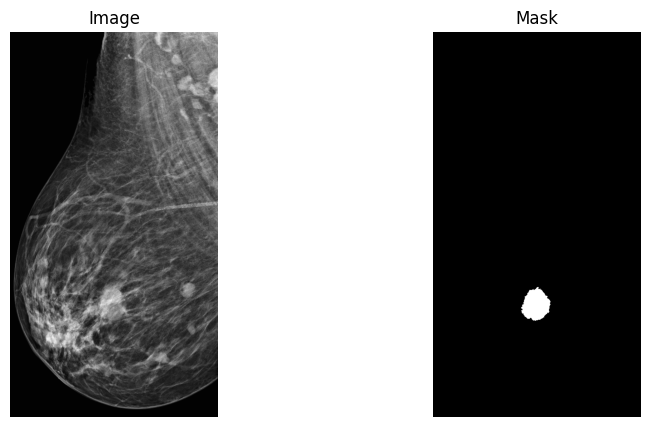

Unique values in the mask: [0 1]


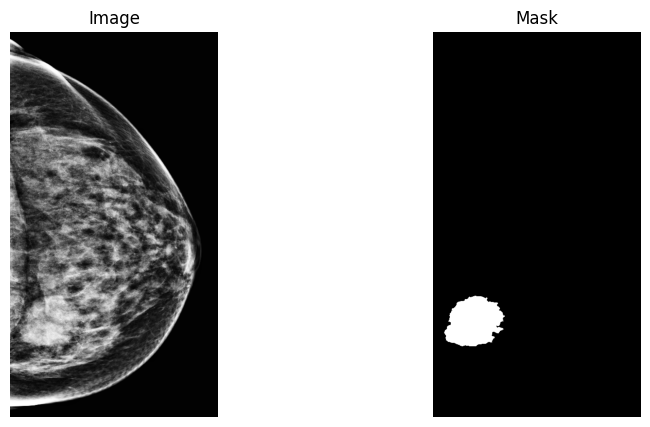

Unique values in the mask: [0 1]


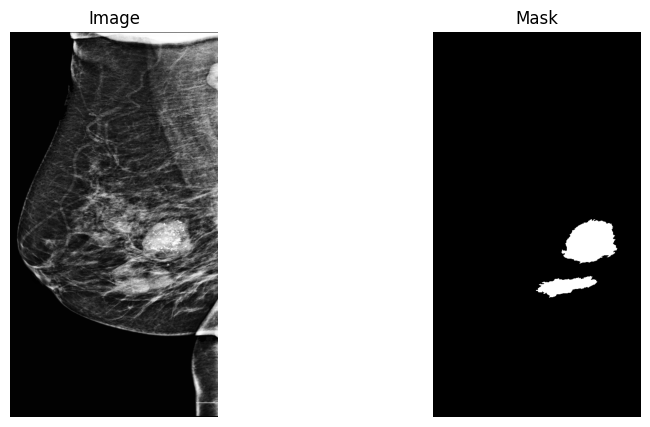

Unique values in the mask: [0 1]


2024-02-21 05:41:26.790552: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [23]:
show_img_mask(dataset=train_dataset, batch=3, image_number=2)

### **Define the Unet Model**

VGG Shaped Unet model Architecture for single-class segmentation

In [24]:
from unet_models import unet_model, res_unet_model, VGG16_UNet, attention_unet_model, attention_res_unet_model

In [25]:
def get_model(model_name):
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)
    
    if model_name == 'simple_unet':
        return unet_model(num_classes=1, input_size=input_shape, num_filters=64, dropout=0.1, batch_norm=False)
    elif model_name == 'simple_resunet':
        return res_unet_model(num_classes=1, input_size=input_shape, num_filters=64, dropout=0.1, batch_norm=False)
    elif model_name == 'vgg_tl_unet': 
        return VGG16_UNet(num_classes=1, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), dropout=0.1, batch_norm=False) # VGG requires 3 channels
    elif model_name == 'attention_unet':
        return attention_unet_model(num_classes=1, input_size=input_shape, num_filters=64, dropout=0.1, batch_norm=False)
    elif model_name == 'attention_resunet':
        return attention_res_unet_model(num_classes=1, input_size=input_shape, num_filters=64, dropout=0.1, batch_norm=False)
    else:
        raise ValueError("Unknown model name")

In [26]:
model = get_model(model_name)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
unet_model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])
display(unet_model_df)

**Compile Model**

test with 
* different optimizers - adam, rmsprop, sgd
* loss functions - binary_crossentropy, iou/jaccard loss, dice loss, combined iou and dice loss, focal loss
* metrics - iou/jaccard, dice coefficient, Fscore

In [27]:
from loss_and_metrics import jaccard_coef, jaccard_loss, dice_coef, dice_loss, combined_jaccard_dice_loss, focal_loss, specificity, precision, recall, f1score

with strategy.scope():
    model = get_model(model_name)
    
    metrics = ['accuracy', f1score, specificity, jaccard_coef, dice_coef]
    
    if loss_name == 'combined_jaccard_dice_loss':
        loss_function = combined_jaccard_dice_loss(alpha=0.5)
    elif loss_name == 'jaccard_loss':
        loss_function = jaccard_loss
    elif loss_name == 'dice_loss':
        loss_function = dice_loss
    elif loss_name == 'focal_loss':
        loss_function = focal_loss
    elif loss_name == 'binary':
        loss_function = 'binary_crossentropy'
    else:
        raise ValueError('Invalid loss function')

    model.compile(optimizer=Adam(lr=1e-5), loss=loss_function, metrics=metrics)

    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "TL-VGG-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 800, 432, 3  0           []                               
                                )]                                                                
                       

 conv2d_11 (Conv2D)             (None, 200, 108, 25  1179904     ['concatenate_5[0][0]']          
                                6)                                                                
                                                                                                  
 activation_10 (Activation)     (None, 200, 108, 25  0           ['conv2d_11[0][0]']              
                                6)                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 200, 108, 25  590080      ['activation_10[0][0]']          
                                6)                                                                
                                                                                                  
 activation_11 (Activation)     (None, 200, 108, 25  0           ['conv2d_12[0][0]']              
          

/home/mayura/anaconda3/envs/mammo-net/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**Train the model**

In [29]:
checkpoint_path = logs_directory + '{}_best.hdf5'.format(model_name)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True, 
                                   save_weights_only=False, 
                                   mode='min')

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=7, 
                               verbose=1, 
                               mode='min')

In [30]:
# If starting with pre-trained weights. 
# model.load_weights('???.hdf5')

epochs = 150

start_time = time.time()

history = model.fit(train_dataset, 
                    epochs=epochs, 
                    validation_data=test_dataset, 
                    verbose=1, 
                    shuffle=False,
                    callbacks=[model_checkpoint, early_stopping]
                   )

end_time = time.time()

training_time = end_time - start_time

model.save(logs_directory + '{}.hdf5'.format(model_name))

history_file = results_dir + '{}_history.json'.format(model_name)

with open(history_file, 'w') as f:
    json.dump(history.history, f)

2024-02-21 05:41:28.206560: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 213
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
     

Epoch 1/150


2024-02-21 05:41:28.313693: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-02-21 05:41:33.863958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2024-02-21 05:41:43.080020: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


27/27 [==============================] - ETA: 0s - loss: 9.3190 - accuracy: 0.2401 - f1score: 0.0352 - specificity: 0.3732 - jaccard_coef: 0.0180 - dice_coef: 0.0352

2024-02-21 05:44:38.399992: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 54
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      


Epoch 1: val_loss improved from inf to 9.20636, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5


2024-02-21 05:45:00.786432: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


27/27 [==============================] - 213s 5s/step - loss: 9.3190 - accuracy: 0.2401 - f1score: 0.0352 - specificity: 0.3732 - jaccard_coef: 0.0180 - dice_coef: 0.0352 - val_loss: 9.2064 - val_accuracy: 0.3510 - val_f1score: 0.0471 - val_specificity: 0.4422 - val_jaccard_coef: 0.0242 - val_dice_coef: 0.0471
Epoch 2/150


2024-02-21 05:45:01.031773: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


27/27 [==============================] - ETA: 0s - loss: 9.1124 - accuracy: 0.7081 - f1score: 0.0485 - specificity: 0.6174 - jaccard_coef: 0.0249 - dice_coef: 0.0485
Epoch 2: val_loss improved from 9.20636 to 8.99100, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 536ms/step - loss: 9.1124 - accuracy: 0.7081 - f1score: 0.0485 - specificity: 0.6174 - jaccard_coef: 0.0249 - dice_coef: 0.0485 - val_loss: 8.9910 - val_accuracy: 0.9278 - val_f1score: 0.0728 - val_specificity: 0.7896 - val_jaccard_coef: 0.0379 - val_dice_coef: 0.0728
Epoch 3/150
27/27 [==============================] - ETA: 0s - loss: 8.8942 - accuracy: 0.9580 - f1score: 0.0795 - specificity: 0.8725 - jaccard_coef: 0.0416 - dice_coef: 0.0795
Epoch 3: val_loss improved from 8.99100 to 8.75925, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/v

27/27 [==============================] - ETA: 0s - loss: 6.6699 - accuracy: 0.9835 - f1score: 0.4982 - specificity: 0.9910 - jaccard_coef: 0.3367 - dice_coef: 0.4982
Epoch 14: val_loss improved from 6.69878 to 6.56854, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 15s 540ms/step - loss: 6.6699 - accuracy: 0.9835 - f1score: 0.4982 - specificity: 0.9910 - jaccard_coef: 0.3367 - dice_coef: 0.4982 - val_loss: 6.5685 - val_accuracy: 0.9809 - val_f1score: 0.5383 - val_specificity: 0.9891 - val_jaccard_coef: 0.3762 - val_dice_coef: 0.5383
Epoch 15/150
27/27 [==============================] - ETA: 0s - loss: 6.5212 - accuracy: 0.9846 - f1score: 0.5191 - specificity: 0.9922 - jaccard_coef: 0.3560 - dice_coef: 0.5191
Epoch 15: val_loss improved from 6.56854 to 6.44181, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_los

27/27 [==============================] - ETA: 0s - loss: 5.2721 - accuracy: 0.9882 - f1score: 0.6257 - specificity: 0.9946 - jaccard_coef: 0.4636 - dice_coef: 0.6257
Epoch 26: val_loss improved from 5.35204 to 5.26447, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 531ms/step - loss: 5.2721 - accuracy: 0.9882 - f1score: 0.6257 - specificity: 0.9946 - jaccard_coef: 0.4636 - dice_coef: 0.6257 - val_loss: 5.2645 - val_accuracy: 0.9842 - val_f1score: 0.5961 - val_specificity: 0.9925 - val_jaccard_coef: 0.4336 - val_dice_coef: 0.5961
Epoch 27/150
27/27 [==============================] - ETA: 0s - loss: 5.1826 - accuracy: 0.9884 - f1score: 0.6309 - specificity: 0.9946 - jaccard_coef: 0.4693 - dice_coef: 0.6309
Epoch 27: val_loss improved from 5.26447 to 5.17973, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_los

27/27 [==============================] - ETA: 0s - loss: 4.3458 - accuracy: 0.9904 - f1score: 0.6905 - specificity: 0.9963 - jaccard_coef: 0.5363 - dice_coef: 0.6905
Epoch 38: val_loss improved from 4.46511 to 4.40273, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 538ms/step - loss: 4.3458 - accuracy: 0.9904 - f1score: 0.6905 - specificity: 0.9963 - jaccard_coef: 0.5363 - dice_coef: 0.6905 - val_loss: 4.4027 - val_accuracy: 0.9853 - val_f1score: 0.6114 - val_specificity: 0.9939 - val_jaccard_coef: 0.4483 - val_dice_coef: 0.6114
Epoch 39/150
27/27 [==============================] - ETA: 0s - loss: 4.2786 - accuracy: 0.9906 - f1score: 0.6969 - specificity: 0.9964 - jaccard_coef: 0.5439 - dice_coef: 0.6969
Epoch 39: val_loss improved from 4.40273 to 4.34270, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_los

27/27 [==============================] - ETA: 0s - loss: 3.6417 - accuracy: 0.9924 - f1score: 0.7528 - specificity: 0.9974 - jaccard_coef: 0.6130 - dice_coef: 0.7528
Epoch 50: val_loss improved from 3.81625 to 3.77073, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 15s 540ms/step - loss: 3.6417 - accuracy: 0.9924 - f1score: 0.7528 - specificity: 0.9974 - jaccard_coef: 0.6130 - dice_coef: 0.7528 - val_loss: 3.7707 - val_accuracy: 0.9863 - val_f1score: 0.6156 - val_specificity: 0.9955 - val_jaccard_coef: 0.4518 - val_dice_coef: 0.6156
Epoch 51/150
27/27 [==============================] - ETA: 0s - loss: 3.5920 - accuracy: 0.9925 - f1score: 0.7574 - specificity: 0.9975 - jaccard_coef: 0.6189 - dice_coef: 0.7574
Epoch 51: val_loss improved from 3.77073 to 3.72645, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_los

27/27 [==============================] - ETA: 0s - loss: 3.1528 - accuracy: 0.9933 - f1score: 0.7866 - specificity: 0.9979 - jaccard_coef: 0.6576 - dice_coef: 0.7866
Epoch 62: val_loss improved from 3.37587 to 3.32914, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 528ms/step - loss: 3.1528 - accuracy: 0.9933 - f1score: 0.7866 - specificity: 0.9979 - jaccard_coef: 0.6576 - dice_coef: 0.7866 - val_loss: 3.3291 - val_accuracy: 0.9869 - val_f1score: 0.6148 - val_specificity: 0.9968 - val_jaccard_coef: 0.4505 - val_dice_coef: 0.6148
Epoch 63/150
27/27 [==============================] - ETA: 0s - loss: 3.1193 - accuracy: 0.9935 - f1score: 0.7904 - specificity: 0.9981 - jaccard_coef: 0.6626 - dice_coef: 0.7904
Epoch 63: val_loss improved from 3.32914 to 3.29451, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_los

27/27 [==============================] - ETA: 0s - loss: 2.8342 - accuracy: 0.9945 - f1score: 0.8255 - specificity: 0.9984 - jaccard_coef: 0.7120 - dice_coef: 0.8255
Epoch 74: val_loss improved from 3.07069 to 3.05317, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 534ms/step - loss: 2.8342 - accuracy: 0.9945 - f1score: 0.8255 - specificity: 0.9984 - jaccard_coef: 0.7120 - dice_coef: 0.8255 - val_loss: 3.0532 - val_accuracy: 0.9868 - val_f1score: 0.6252 - val_specificity: 0.9959 - val_jaccard_coef: 0.4613 - val_dice_coef: 0.6252
Epoch 75/150
27/27 [==============================] - ETA: 0s - loss: 2.8132 - accuracy: 0.9946 - f1score: 0.8281 - specificity: 0.9984 - jaccard_coef: 0.7156 - dice_coef: 0.8281
Epoch 75: val_loss improved from 3.05317 to 3.03575, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_los

27/27 [==============================] - ETA: 0s - loss: 2.6345 - accuracy: 0.9951 - f1score: 0.8434 - specificity: 0.9987 - jaccard_coef: 0.7368 - dice_coef: 0.8434
Epoch 86: val_loss improved from 2.89382 to 2.88078, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 530ms/step - loss: 2.6345 - accuracy: 0.9951 - f1score: 0.8434 - specificity: 0.9987 - jaccard_coef: 0.7368 - dice_coef: 0.8434 - val_loss: 2.8808 - val_accuracy: 0.9851 - val_f1score: 0.6233 - val_specificity: 0.9928 - val_jaccard_coef: 0.4595 - val_dice_coef: 0.6233
Epoch 87/150
27/27 [==============================] - ETA: 0s - loss: 2.6365 - accuracy: 0.9947 - f1score: 0.8328 - specificity: 0.9985 - jaccard_coef: 0.7209 - dice_coef: 0.8328
Epoch 87: val_loss improved from 2.88078 to 2.86710, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_los

Epoch 99/150
27/27 [==============================] - ETA: 0s - loss: 2.4919 - accuracy: 0.9954 - f1score: 0.8575 - specificity: 0.9986 - jaccard_coef: 0.7593 - dice_coef: 0.8575
Epoch 99: val_loss improved from 2.76093 to 2.75381, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 531ms/step - loss: 2.4919 - accuracy: 0.9954 - f1score: 0.8575 - specificity: 0.9986 - jaccard_coef: 0.7593 - dice_coef: 0.8575 - val_loss: 2.7538 - val_accuracy: 0.9868 - val_f1score: 0.6272 - val_specificity: 0.9960 - val_jaccard_coef: 0.4639 - val_dice_coef: 0.6272
Epoch 100/150
27/27 [==============================] - ETA: 0s - loss: 2.4822 - accuracy: 0.9954 - f1score: 0.8588 - specificity: 0.9986 - jaccard_coef: 0.7612 - dice_coef: 0.8588
Epoch 100: val_loss improved from 2.75381 to 2.74852, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_j

27/27 [==============================] - 14s 537ms/step - loss: 2.3946 - accuracy: 0.9957 - f1score: 0.8661 - specificity: 0.9988 - jaccard_coef: 0.7718 - dice_coef: 0.8661 - val_loss: 2.6634 - val_accuracy: 0.9865 - val_f1score: 0.6318 - val_specificity: 0.9951 - val_jaccard_coef: 0.4690 - val_dice_coef: 0.6318
Epoch 112/150
27/27 [==============================] - ETA: 0s - loss: 2.3853 - accuracy: 0.9957 - f1score: 0.8680 - specificity: 0.9988 - jaccard_coef: 0.7750 - dice_coef: 0.8680
Epoch 112: val_loss improved from 2.66340 to 2.65921, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 534ms/step - loss: 2.3853 - accuracy: 0.9957 - f1score: 0.8680 - specificity: 0.9988 - jaccard_coef: 0.7750 - dice_coef: 0.8680 - val_loss: 2.6592 - val_accuracy: 0.9860 - val_f1score: 0.6295 - val_specificity: 0.9942 - val_jaccard_coef: 0.4665 - val_dice_coef: 0.6296
Epo

27/27 [==============================] - 14s 530ms/step - loss: 2.3205 - accuracy: 0.9956 - f1score: 0.8617 - specificity: 0.9987 - jaccard_coef: 0.7648 - dice_coef: 0.8617 - val_loss: 2.5769 - val_accuracy: 0.9871 - val_f1score: 0.6384 - val_specificity: 0.9961 - val_jaccard_coef: 0.4778 - val_dice_coef: 0.6384
Epoch 125/150
27/27 [==============================] - ETA: 0s - loss: 2.3152 - accuracy: 0.9956 - f1score: 0.8615 - specificity: 0.9987 - jaccard_coef: 0.7643 - dice_coef: 0.8615
Epoch 125: val_loss improved from 2.57695 to 2.57129, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 530ms/step - loss: 2.3152 - accuracy: 0.9956 - f1score: 0.8615 - specificity: 0.9987 - jaccard_coef: 0.7643 - dice_coef: 0.8615 - val_loss: 2.5713 - val_accuracy: 0.9870 - val_f1score: 0.6387 - val_specificity: 0.9958 - val_jaccard_coef: 0.4777 - val_dice_coef: 0.6387
Epo

Epoch 138/150
27/27 [==============================] - ETA: 0s - loss: 2.2813 - accuracy: 0.9950 - f1score: 0.8416 - specificity: 0.9987 - jaccard_coef: 0.7343 - dice_coef: 0.8416
Epoch 138: val_loss improved from 2.52026 to 2.51560, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/vgg_unet_model_best_weights.hdf5
27/27 [==============================] - 14s 533ms/step - loss: 2.2813 - accuracy: 0.9950 - f1score: 0.8416 - specificity: 0.9987 - jaccard_coef: 0.7343 - dice_coef: 0.8416 - val_loss: 2.5156 - val_accuracy: 0.9848 - val_f1score: 0.6365 - val_specificity: 0.9914 - val_jaccard_coef: 0.4742 - val_dice_coef: 0.6365
Epoch 139/150
27/27 [==============================] - ETA: 0s - loss: 2.3469 - accuracy: 0.9930 - f1score: 0.7834 - specificity: 0.9976 - jaccard_coef: 0.6531 - dice_coef: 0.7834
Epoch 139: val_loss improved from 2.51560 to 2.49929, saving model to ../../logs/annotation_class_pixels/vgg-unet/malignant_mass/combined

In [ ]:
print(f"Training time: {training_time} seconds")

### **Evaluations**

**Accuracy and Loss**

In [ ]:
loss_val, acc, f1, spec, iou, dice = model.evaluate(test_dataset)

content = f"""
Loss: {loss_val}
Accuracy: {acc}
F1-Score: {f1}
Specificity: {spec}
IoU / Jaccard Coeff: {iou}
Dice Coeff: {dice}
"""

print(content)

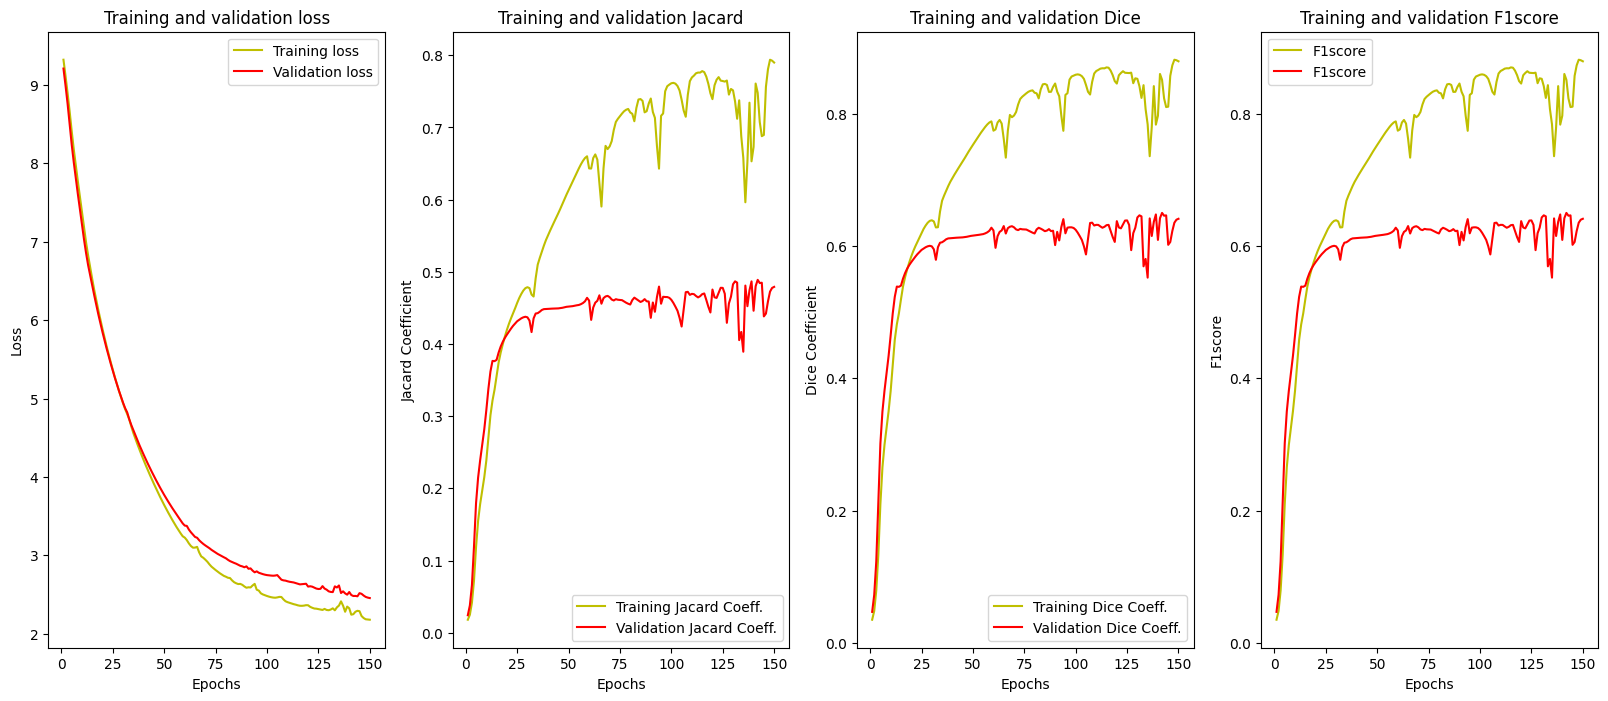

In [32]:
#plot the training and validation accuracy and loss at each epoch

fig, axs = plt.subplots(1, 4, figsize=(20, 8))

# Plot the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].plot(epochs, loss, 'y', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and validation Jaccard Coef
jc = history.history['jaccard_coef']
val_jc = history.history['val_jaccard_coef']
axs[1].plot(epochs, jc, 'y', label='Training Jacard Coeff.')
axs[1].plot(epochs, val_jc, 'r', label='Validation Jacard Coeff.')
axs[1].set_title('Training and validation Jacard')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Jacard Coefficient')
axs[1].legend()

dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']
axs[2].plot(epochs, dice, 'y', label='Training Dice Coeff.')
axs[2].plot(epochs, val_dice, 'r', label='Validation Dice Coeff.')
axs[2].set_title('Training and validation Dice')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

fs = history.history['f1score']
val_fs = history.history['val_f1score']
axs[3].plot(epochs, fs, 'y', label='F1score')
axs[3].plot(epochs, val_fs, 'r', label='F1score')
axs[3].set_title('Training and validation F1score')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('F1score')
axs[3].legend()

plt.show()

fig.savefig(os.path.join(results_dir, 'training_validation_metrics.png'))

In [33]:
from tensorflow.keras.models import load_model

model = load_model(checkpoint_path, compile=False)  

model.compile(optimizer=Adam(lr=1e-5), loss=loss_function, metrics=metrics)

In [ ]:
loss, accuracy, f1score, specificity, iou, dice = model.evaluate(test_dataset)

content = f"""
---------------------------------------------
Model: {model_name}
---------------------------------------------
Loss Function: {loss_name}

Training completed in: {training_time} seconds

Loss: {loss}
Accuracy: {accuracy}
F1-Score: {f1score}
Specificity: {specificity}
IoU / Jaccard Coeff: {iou}
Dice Coeff: {dice}
"""

print(content)

filename = os.path.join(results_dir, 'model_evaluation_results.txt')

with open(filename, 'w') as file:
    file.write(content)

print("The evaluation metrics have been saved to:", filename)

**Average IoU Score**

In [34]:
threshold=0.7

In [35]:
def calculate_iou_per_image(y_true, y_pred):

    intersection = np.logical_and(y_true, y_pred > threshold).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return float('nan')  # Avoid division by zero; handle as you see fit
    else:
        return intersection / union

In [36]:
def calculate_mean_iou(test_dataset, model):

    ious = []
    for images, true_masks in test_dataset:
        pred_masks = model.predict(images)
        for i in range(images.shape[0]):  # Iterate through the batch
            iou = calculate_iou_per_image(true_masks[i].numpy(), (pred_masks[i] > 0.5).astype(int))
            if not np.isnan(iou):
                ious.append(iou)
    
    return np.nanmean(ious)

mean_iou = calculate_mean_iou(test_dataset, model)

mean_iou_content = f"Mean IoU = {mean_iou}"

print(mean_iou_content)

with open(filename, 'a') as file:
    file.write('\n' + mean_iou_content)

print("Mean IoU has been added to:", filename)

1/1 [==============================] - 0s 21ms/step
Mean IoU = [0.4791099]
Mean IoU has been added to: ../../results/annotation_class_pixels/vgg-unet/malignant_mass/combined_jaccard_dice_loss/model_evaluation_results.txt


Area Under Curve

In [ ]:
y_true = []
y_pred = []

for images, masks in test_dataset:
    predictions = model.predict(images)
    perdictions = predictions > threshold
    y_pred.extend(predictions.flatten())
    y_true.extend(masks.numpy().flatten())

y_true = tf.convert_to_tensor(y_true)
y_pred = tf.convert_to_tensor(y_pred)

auc = tf.keras.metrics.AUC()
auc.update_state(y_true, y_pred)
auc_result = auc.result().numpy()

auc_result_content = f'AUC = {auc_result}'
print(auc_result_content)

with open(filename, 'a') as file:
    file.write('\n' + auc_result_content)

print("AUC has been added to:", filename)

**Confusion Matrix**

1/1 [==============================] - 0s 24ms/step


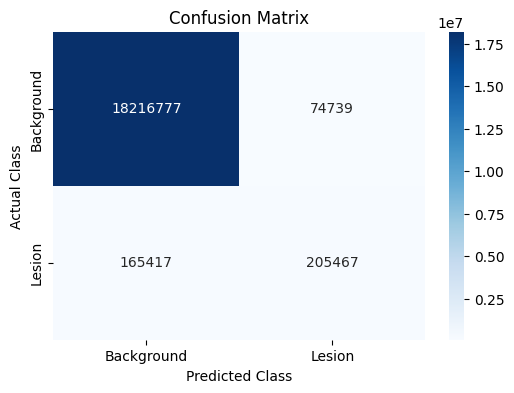

<Figure size 640x480 with 0 Axes>

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


all_true_labels = []
all_predicted_labels = []

for images, masks in test_dataset:
    y_pred = model.predict(images)
    
    # y_pred = tf.math.round(y_pred)  # convert pred probs to binary preds (0 or 1)
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(masks, tf.float32)
    
    all_predicted_labels.extend(y_pred.numpy().flatten())
    all_true_labels.extend(y_true.numpy().flatten())
    
    del y_pred, y_true
    gc.collect()

cm = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(6, 4))

class_names = ['Background', 'Lesion']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'))
plt.show()
plt.clf()

## **Predictions**

**Predict on Test Image**

1/1 [==============================] - 0s 33ms/step


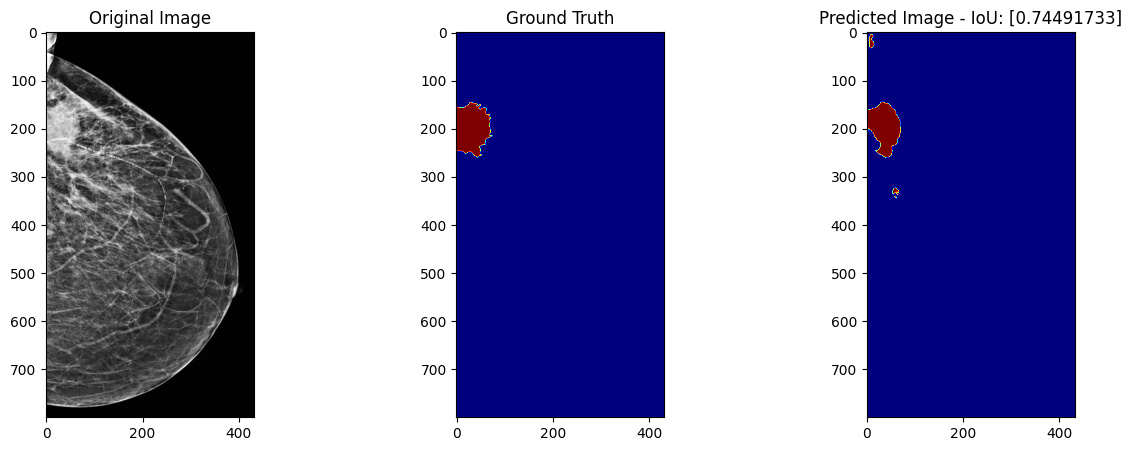

<Figure size 640x480 with 0 Axes>

In [38]:
def check_predictions(dataset, batch, img):
    for images, masks in dataset.take(batch):

        predicted_masks = model.predict(images)

        # predicted_masks = tf.math.round(predicted_masks)
        predicted_masks = tf.cast(predicted_masks > threshold, tf.float32)

        true_masks = tf.cast(masks, tf.float32)
        
        iou = calculate_iou_per_image(true_masks[img], predicted_masks[img])

        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(images[img])
        plt.title("Original Image")

        plt.subplot(132)
        plt.imshow(true_masks[img], cmap='jet')
        plt.title("Ground Truth")

        plt.subplot(133)
        plt.imshow(predicted_masks[img], cmap='jet')
        plt.title(f"Predicted Image - IoU: {iou:.4f}")
        
        plt.savefig(os.path.join(results_dir, 'predictions_on_test_image.png'))

        plt.show()
    
        plt.clf()
        
check_predictions(dataset=test_dataset, batch=1, img=5)

**Predict on Unseen Data**

1/1 [==============================] - 2s 2s/step


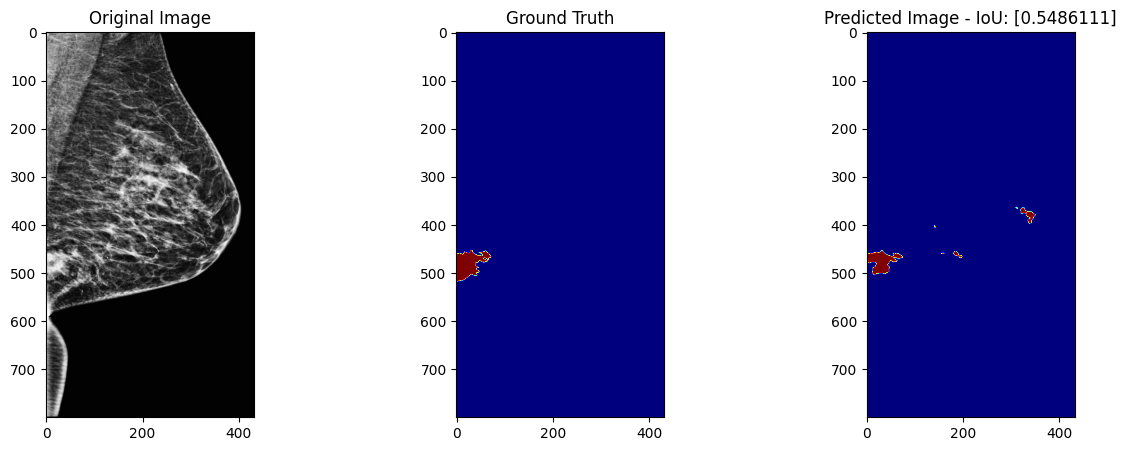

<Figure size 640x480 with 0 Axes>

In [39]:
def predict_single_image_mask(model, image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    image, mask = wrap_preprocessing(image, mask)
    image = tf.image.resize(image, image_size)
    image = image / 255
    image = tf.image.grayscale_to_rgb(image)
    mask = tf.image.resize(mask, image_size, method='nearest')
    mask = tf.math.round(mask / mask_gray_value)
    
    image = tf.expand_dims(image, axis=0)
    mask = tf.expand_dims(mask, axis=0)
    
    predicted_mask = model.predict(image)
    
    # predicted_mask = tf.math.round(predicted_mask)
    predicted_mask = tf.cast(predicted_mask > threshold, tf.float32)
    iou = calculate_iou_per_image(mask, predicted_mask)

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(image[0])
    plt.title("Original Image")

    plt.subplot(132)
    plt.imshow(mask[0], cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(133)
    plt.imshow(predicted_mask[0], cmap='jet')
    plt.title(f"Predicted Image - IoU: {iou:.4f}")
    
    plt.savefig(os.path.join(results_dir, 'predictions_on_unseen_image.png'))
    
    plt.show()
    
    plt.clf()
    
predict_single_image_mask(model, image_files_unseen, mask_files_unseen)

In [40]:
# def predict_single_image(model, image_path):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_image(image, channels=1)
#     image, _ = wrap_preprocessing(image, np.zeros(image.shape))
#     image = tf.image.resize(image, image_size)
#     image = image / 255
    
#     image = tf.expand_dims(image, axis=0)
    
#     predicted_mask = model.predict(image)
    
#     predicted_mask = tf.math.round(predicted_mask)
    
#     plt.figure(figsize=(10, 5))
#     plt.subplot(121)
#     plt.imshow(image[0])
#     plt.title("Original Image")
    
#     plt.subplot(122)
#     plt.imshow(predicted_mask[0], cmap='jet')
#     plt.title("Predicted Image")
    
#     plt.show()

# image_path = '/kaggle/input/unseen/0248-LCC.png'
# predict_single_image(model, image_path)